# Project 3 - Activity Classification
# Josh Mandzak, Tanner Thornton, Coby White

### First up, grab and collect all the data

In [199]:
import pandas as pd
import os

directories = ['Downstairs', 'Upstairs', 'Walking data', 'Squats', 'Standing']
dataframes = [
    [],
    [],
    [],
    [],
    []
]
cwd = os.getcwd()
cols_to_drop = ['LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)', 'LIGHT (lux)']
 
for i in range(3):
    path = cwd + '/' + directories[i]
    for filename in os.listdir(path):
        df = pd.read_csv(path + '/' + filename, sep=';')
        df.drop(columns=df.columns[16:], axis=1,  inplace=True)
        df.drop(columns=cols_to_drop, inplace=True)
        dataframes[i].append(df)


In [200]:
# Now read the files from the other app
for i in range(3, 5):
    path = cwd + '/' + directories[i] + '/'
    temp_dfs = []
    for filename in os.listdir(path):
        df = pd.read_csv(path + filename)
        df.drop(columns=['seconds_elapsed'], inplace=True)
        df = df.iloc[::50, :]
        temp_dfs.append(df)

    main_df = temp_dfs[0]
    for j in range(1, len(temp_dfs)):
        main_df = pd.merge(main_df, temp_dfs[j], on='time')
    main_df.drop(columns=['time'], inplace=True)
    dataframes[i].append(main_df)

### Create Function to Split Dataframes into Samples samples_per_split/2 seconds long
### AKA, perform WINDOWING

In [201]:
def splitSamples(dataframes: list, samples_per_split: int) -> list:
    all_samples = []
    for df in dataframes:
        start_index = 0
        end_index = samples_per_split
        while end_index < len(df):
            temp_df = df[start_index:end_index]
            all_samples.append(temp_df)
            start_index += samples_per_split // 2
            end_index += samples_per_split // 2
    
    return all_samples

In [202]:
# Call the function with each dataframe to get sample lists
SAMPLES_PER_SPLIT = 8
downstairs_dfs = splitSamples(dataframes[0], SAMPLES_PER_SPLIT)
upstairs_dfs = splitSamples(dataframes[1], SAMPLES_PER_SPLIT)
walk_dfs = splitSamples(dataframes[2], SAMPLES_PER_SPLIT)
squat_dfs = splitSamples(dataframes[3], SAMPLES_PER_SPLIT)
standing_dfs = splitSamples(dataframes[4], SAMPLES_PER_SPLIT)


In [203]:
print(len(downstairs_dfs))
print(len(upstairs_dfs))
print(len(walk_dfs))
print(len(squat_dfs))
print(len(standing_dfs))

593
616
7138
53
79


### Feature Engineering

In [204]:
import numpy as np

# function to create list of lists from list of dataframes
def createX(dataframes: list, columns_to_use: list, use_raw_measurements: bool, use_features: bool) -> list:
    X = []
    for df in dataframes:
        sample = []
        for column in columns_to_use:
            # raw measurements as features
            if use_raw_measurements:
                sample.append(df[column].tolist())
            
            # features collected through feature engineering
            if use_features:
                additional_features = []
                measurement = df[column].tolist()
                additional_features.append(np.median(np.absolute(measurement - np.mean(measurement)))) # median absolute deviation
                additional_features.append(np.mean(measurement)) # mean
                additional_features.append(np.std(measurement)) # standard deviation
                additional_features.append(np.min(measurement)) # min
                additional_features.append(np.max(measurement)) # max
                additional_features.append(np.sum(np.power(measurement, 2) / len(measurement))) # sum of squares divided by num samples (energy measure)
                sample.append(additional_features)

        flat_sample = [item for sublist in sample for item in sublist]
        X.append(flat_sample.copy())
    
    return X

In [205]:
# DOWNSAMPLING WALKING
walk_dfs = walk_dfs[:600]

In [206]:
# COLUMNS WE ARE USING
used_columns = ['ACCELEROMETER Z (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER X (m/s²)', 'MAGNETIC FIELD Z (μT)',
       'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD X (μT)', 'GYROSCOPE Z (rad/s)',
       'GYROSCOPE Y (rad/s)', 'GYROSCOPE X (rad/s)', 'GRAVITY Z (m/s²)',
       'GRAVITY Y (m/s²)', 'GRAVITY X (m/s²)']
       
# create list of lists for each activity
downstairs_samples_raw = createX(downstairs_dfs, used_columns, True, False)
upstairs_samples_raw = createX(upstairs_dfs, used_columns, True, False)
walk_samples_raw = createX(walk_dfs, used_columns, True, False)
squat_samples_raw = createX(squat_dfs, used_columns, True, False)
standing_samples_raw = createX(standing_dfs, used_columns, True, False)

downstairs_samples_features = createX(downstairs_dfs, used_columns, False, True)
upstairs_samples_features = createX(upstairs_dfs, used_columns, False, True)
walk_samples_features = createX(walk_dfs, used_columns, False, True)
squat_samples_features = createX(squat_dfs, used_columns, False, True)
standing_samples_features = createX(standing_dfs, used_columns, False, True)

downstairs_samples_both = createX(downstairs_dfs, used_columns, True, True)
upstairs_samples_both = createX(upstairs_dfs, used_columns, True, True)
walk_samples_both = createX(walk_dfs, used_columns, True, True)
squat_samples_both = createX(squat_dfs, used_columns, True, True)
standing_samples_both = createX(standing_dfs, used_columns, True, True)

### Some more preprocessing and creation of y

In [207]:
# Create y
# NOTE: y should be the same regardless of our x features, so we can just use length of raw
y = []

for i in range(len(downstairs_samples_raw)):
    y.append(0)
for i in range(len(upstairs_samples_raw)):
    y.append(1)
for i in range(len(walk_samples_raw)):
    y.append(2)
for i in range(len(squat_samples_raw)):
    y.append(3)
for i in range(len(standing_samples_raw)):
    y.append(4)

# Create full X lists
X_raw = downstairs_samples_raw + upstairs_samples_raw + walk_samples_raw + squat_samples_raw + standing_samples_raw
X_features = downstairs_samples_features + upstairs_samples_features + walk_samples_features + squat_samples_features + standing_samples_features
X_both = downstairs_samples_both + upstairs_samples_both + walk_samples_both + squat_samples_both + standing_samples_both

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_raw = sc.fit_transform(X_raw)
X_features = sc.fit_transform(X_features)
X_both = sc.fit_transform(X_both)

### Plug it into a model and see how it does

In [208]:
# Train and evaluate the model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_model(X, y, model):
    # Do the K-fold cross validation
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # This function sets an empty array of size len(y)
    # It then does the predictions for each fold (retraining the model each time)
    # and fills in the prediction in the correct spot in the array. By the end of it,
    # you will have your y array and a new array (predictions) of guesses for each sample
    # this is because Kfold uses each sample once for test data.
    predictions = cross_val_predict(model, X, y, cv=cv)

    # we can use this to create a confusion matrix
    new_labels = ['Downstairs', 'Upstairs', 'Walking', 'Squat', 'Standing']
    old_labels = [0, 1, 2, 3, 4]
    cm = confusion_matrix(y, predictions)
    plt.matshow(cm, cmap=plt.cm.Blues)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xticks(ticks=old_labels, labels=new_labels)
    plt.yticks(ticks=old_labels, labels=new_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Label')
    
    print(f'All accuracy scores from 10 folds:')
    for score in scores:
        print(f'{round(score * 100, 2)}%', end=' ')
    print()
    print(f'Mean Accuracy from 10 Fold Cross-Validation: {round(np.mean(scores)*100, 2)}%\n')

### RESULTS

### MODEL: RandomForest, Raw Measurements Only

All accuracy scores from 10 folds:
73.33% 86.08% 83.51% 83.51% 77.84% 84.54% 96.91% 71.13% 69.59% 62.37% 
Mean Accuracy from 10 Fold Cross-Validation: 78.88%



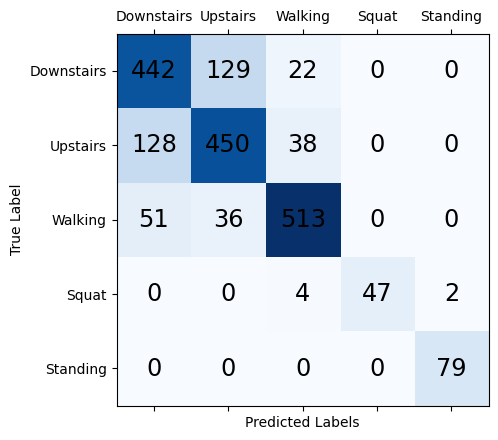

In [209]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_raw, y, model)

### Model: XGBoost, Raw Measurements Only

All accuracy scores from 10 folds:
72.82% 86.08% 86.08% 86.08% 79.38% 84.02% 96.91% 73.2% 70.1% 69.07% 
Mean Accuracy from 10 Fold Cross-Validation: 80.37%



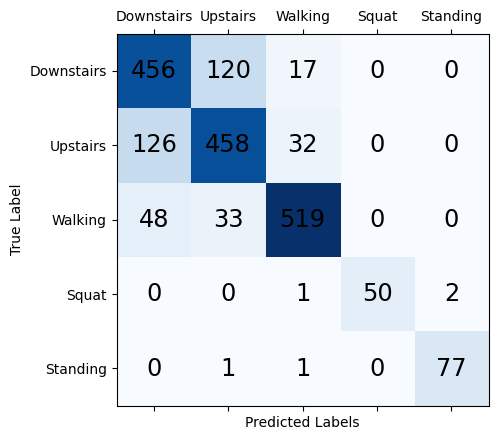

In [210]:
from xgboost import XGBClassifier

model = XGBClassifier()
train_and_evaluate_model(X_raw, y, model)

### Model: RandomForest, Features Only

All accuracy scores from 10 folds:
76.41% 89.18% 90.21% 77.84% 81.44% 85.05% 96.39% 71.65% 69.07% 67.53% 
Mean Accuracy from 10 Fold Cross-Validation: 80.48%



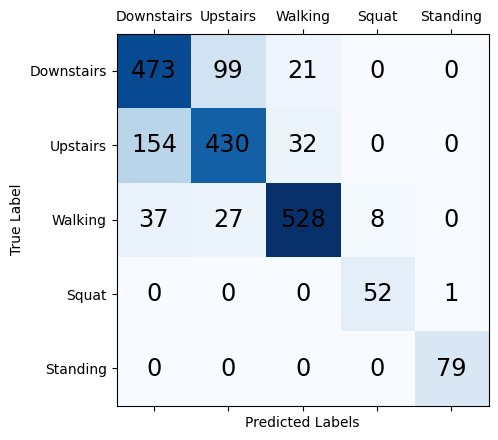

In [211]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_features, y, model)

### Model: XGBoost, Features Only

All accuracy scores from 10 folds:
78.97% 90.72% 88.66% 80.41% 80.93% 84.54% 94.85% 77.32% 69.59% 68.56% 
Mean Accuracy from 10 Fold Cross-Validation: 81.45%



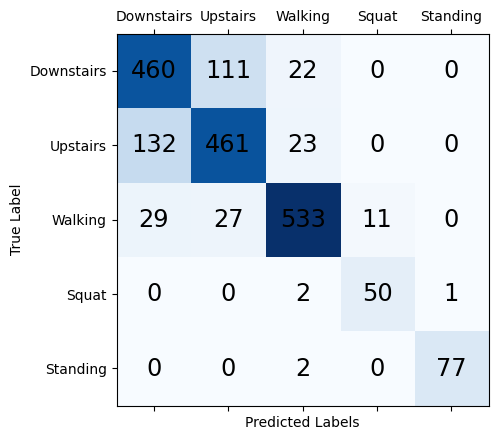

In [212]:
from xgboost import XGBClassifier

model = XGBClassifier()
train_and_evaluate_model(X_features, y, model)

### Model: RandomForest, Raw Measurements And Features

All accuracy scores from 10 folds:
74.87% 89.18% 87.63% 84.54% 81.44% 86.08% 96.39% 69.59% 68.56% 64.95% 
Mean Accuracy from 10 Fold Cross-Validation: 80.32%



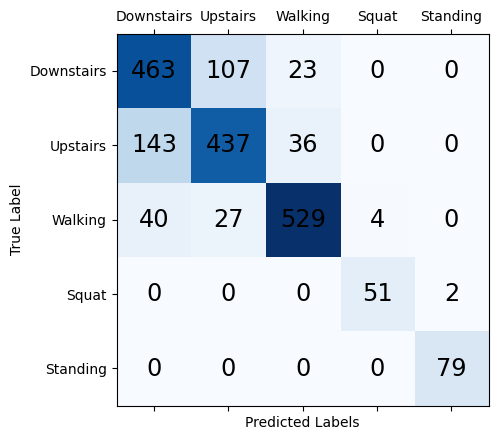

In [213]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(X_both, y, model)

### Model: XGBoost, Raw Measurements And Features

All accuracy scores from 10 folds:
77.44% 90.21% 90.21% 79.9% 80.93% 84.02% 96.91% 75.26% 70.1% 69.59% 
Mean Accuracy from 10 Fold Cross-Validation: 81.45%



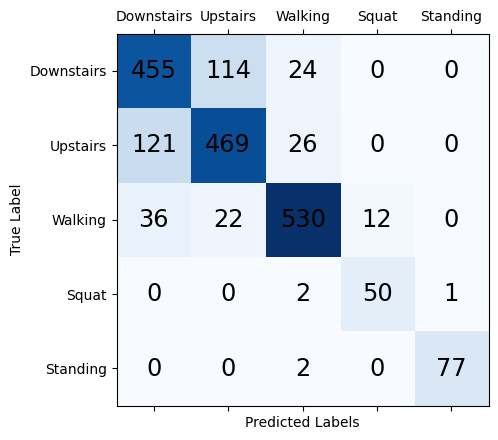

In [214]:
from xgboost import XGBClassifier

model = XGBClassifier()
train_and_evaluate_model(X_both, y, model)